# LIGO Project
## PyCBC GW Match

In [36]:
# Filter the LIGO .gwf data file using the pyCBC software package
# Based on Alex Nitz's sample code
# Some lines added by Hao Liu to parameterize the program and for outputs

directory = 'Data/' # directory where the data files are located
suffix = '_LOSC_4_V2-1126257414-4096' # suffix of the file name, not including ".gwf"
match_low_frequency_cutoff = 15 # low frequency cutoff for matching, normally chosen to be same as highpass_freq
highpass_freq = 15 # frequency for the initial high pass (Hz)
highpass_edge_cut_left = 16 # time domain left-side cutoff after initial high pass (in second)
highpass_edge_cut_right = 16 # time domain right-side cutoff after initial high pass (in second)
snr_edge_cut = 8 # length of edge-cut at both ends for max-SNR determination. 2016
psd_segment_length = 16 # segment length for calculating the PSD by Welch's averaging 4

import lal as _lal
from pycbc.frame import read_frame
from pycbc.filter import highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.types.timeseries import load_timeseries
from pycbc.types.frequencyseries import load_frequencyseries
from pycbc.types.timeseries import TimeSeries
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
from pycbc.waveform import apply_fseries_time_shift
from pycbc.filter import sigma

%matplotlib notebook
import h5py
import json
import numpy as np
import readligo as rl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.signal import tukey
from scipy.interpolate import interp1d
from scipy.stats import skew, kurtosis
from numpy.fft import rfft, rfftfreq
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

In [37]:
print('Start to read and high-pass the data, will cut some edge after that.')

t_slice = 64

strain, strain_i, stilde = {}, {}, {}
for ifo in ['H', 'L']:
    # Read the detector data
    fname = directory + '%s-%s1' % (ifo, ifo) + suffix + '.gwf'
    channel_name = '%s1:LOSC-STRAIN'  % ifo
    strain_i[ifo] = read_frame(fname, channel_name)
    strain[ifo] = strain_i[ifo].time_slice(1126259462-t_slice/2,1126259462+t_slice/2)

    print(' ')
    print('****************************************************')
    print("%s-file is: %s" %(ifo, fname))
    print("%s-file is from %s to %s, duration: %s" 
        %(ifo, strain[ifo].start_time, strain[ifo].end_time, strain[ifo].duration) )

    # save a copy of the unfiltered strain data to disk
    #strain[ifo].numpy().tofile(directory + '%s-%s1' % (ifo, ifo) + suffix + '_unfilt.bin')

    # Initial high pass to remove the strong low-frequency signal
    #strain_i[ifo] = highpass(strain_i[ifo], highpass_freq) 
    strain[ifo] = highpass(strain[ifo], highpass_freq)

    # Edge-cut to remove time corrupted by the high pass filter
    #strain_i[ifo] = strain_i[ifo].crop(highpass_edge_cut_left, highpass_edge_cut_right)
    strain[ifo] = strain[ifo].crop(highpass_edge_cut_left, highpass_edge_cut_right)

    # Print some information
    print("%s-strain after high-pass is now from %s to %s, duration: %s" 
        %(ifo, strain[ifo].start_time, strain[ifo].end_time, strain[ifo].duration) )

    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()

print(type(strain['H']))

Start to read and high-pass the data, will cut some edge after that.
 
****************************************************
H-file is: Data/H-H1_LOSC_4_V2-1126257414-4096.gwf
H-file is from 1126259430 to 1126259494, duration: 64.0
H-strain after high-pass is now from 1126259446 to 1126259478, duration: 32.0
 
****************************************************
L-file is: Data/L-L1_LOSC_4_V2-1126257414-4096.gwf
L-file is from 1126259430 to 1126259494, duration: 64.0
L-strain after high-pass is now from 1126259446 to 1126259478, duration: 32.0
<class 'pycbc.types.timeseries.TimeSeries'>


In [38]:
print('Calculate the PSD from cut strain...')

psd_method = "pycbc" # Either 'pycbc' or 'losc'
psds = {}

if psd_method == "pycbc":
    print('Using PyCBC method.')
else:
    print('Using LOSC method.')

for ifo in ['H', 'L']:
    
    if psd_method == "pycbc":
        # Calculate the PSD by a Welch-style estimator (with the pyCBC timeseries.psd() method)
        # Then interpolate the PSD to the desired frequency step.
        
        psds[ifo] = interpolate(strain[ifo].psd(psd_segment_length), stilde[ifo].delta_f)
        
        # Smooth to the desired corruption length
        psds[ifo] = inverse_spectrum_truncation(psds[ifo], 
                                                psd_segment_length * strain[ifo].sample_rate,
                                                low_frequency_cutoff=highpass_freq,
                                                trunc_method='hann')
        
        # Whiten strain
        strain[ifo] = (stilde[ifo] / psds[ifo]**0.5 ).to_timeseries()
        
        # Save PSD
        psds[ifo].save('Results/%s' %(ifo) + '_PSD_PYCBC_M_SEG_%s.npy' %(psd_segment_length))
    
    elif psd_method == "losc":
        # Calculate the PSD by a Welch-style estimator (with the mlab.psd() function)
        # Then interpolate, using numpy's interp function, to the desired frequency step.
        
        fs = strain[ifo].sample_rate
        NFFT = psd_segment_length*fs # 4
        psd_window = np.blackman(NFFT)
        NOVL = NFFT/2
        
        Pxx, freqs = mlab.psd(strain[ifo], Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)
        datafreqs = stilde[ifo].sample_frequencies
        psd_tmp = np.interp(datafreqs, freqs, Pxx)
        
        # Save PSD
        np.save('Results/'+'%s' %(ifo) + '_PSD_LOSC_M_SEG_%s.npy' %(psd_segment_length),np.column_stack((datafreqs,psd_tmp)))
    
        psds[ifo] = load_frequencyseries('Results/'+'%s' % (ifo) + '_PSD_LOSC_M_SEG_%s.npy' %(psd_segment_length))
        
        strain[ifo] = (stilde[ifo] / psds[ifo]**0.5 ).to_timeseries()

print('PSD ready.')
print(type(strain['H']))

Calculate the PSD from cut strain...
Using PyCBC method.
PSD ready.
<class 'pycbc.types.timeseries.TimeSeries'>


In [39]:
print('Start matching: ')

hp, hc = get_td_waveform(   approximant="SEOBNRv4", 
                            mass1=41.743, mass2=29.237, 
                            spin1z = 0.355,      spin2z = -0.769, 
                            f_lower=match_low_frequency_cutoff, delta_t = strain[ifo].delta_t)

hp.append_zeros(800)
hc.append_zeros(800)

window = tukey(len(hp), alpha=0.3)
hp._data = hp._data*window
hp.resize(len(strain[ifo]))

hp = hp.to_frequencyseries(delta_f=stilde[ifo].delta_f)

max_snr, max_time, max_phase = {}, {}, {}
for ifo in ['H', 'L']:
    snr = matched_filter(hp, stilde[ifo], psd=psds[ifo], low_frequency_cutoff=match_low_frequency_cutoff)
    snr = snr.crop(snr_edge_cut, snr_edge_cut)
    
    _, idx = snr.abs_max_loc()
      
    # The complex SNR at the peak
    max_snr[ifo] = snr[idx]
        
    # The time of the peak
    max_time[ifo] = float(idx) / snr.sample_rate + snr.start_time
    max_phase[ifo] = np.angle(max_snr[ifo])

    print(' ')
    print('****************************************************')
    print('%s: Consider SNR only from %s to %s, duration: %s' %(ifo, snr.start_time, snr.end_time, snr.duration))
    print('%s-SNR: %s'   %(ifo, np.absolute(max_snr[ifo])))
    print('%s-time: %s'  %(ifo, max_time[ifo]))
    print('%s-phase: %s' %(ifo, max_phase[ifo]))

tmax, hmax, smax = max_time, hp, max_snr

network_snr = (abs(np.array(max_snr.values())) ** 2.0).sum() ** 0.5

Start matching: 
 
****************************************************
H: Consider SNR only from 1126259454 to 1126259470, duration: 16.0
H-SNR: 18.406331819171957
H-time: 1126259461.0078125
H-phase: 2.2518541657045676
 
****************************************************
L: Consider SNR only from 1126259454 to 1126259470, duration: 16.0
L-SNR: 12.142519754217847
L-time: 1126259461.000732422
L-phase: -0.6327146384449882
network SNR: 22.050710578551264
1126259446.0


In [40]:
i_c = 2*4096
nq = 4096./2.
b, a = butter(4, [15./nq, 350./nq], btype = 'bandpass')
wt, h = {}, {}
for ifo in ['H', 'L']:
    # Shift the template to the maximum time at this sample rate
    dt =  tmax[ifo] - stilde[ifo].start_time
    inj = apply_fseries_time_shift(hmax, dt)

    # Scale the template to the SNR and phase
    inj /= sigma(hmax, psd=psds[ifo], low_frequency_cutoff=match_low_frequency_cutoff)
    inj *= smax[ifo]

    amp1 = smax[ifo] / sigma(hmax, psd=psds[ifo], low_frequency_cutoff=match_low_frequency_cutoff)
    amp1 = np.absolute(amp1)
    print('%s relative amplitude: %s' %(ifo, amp1*100))

    # Subtract from the data
    stilde2 = stilde[ifo] - inj
    stilde_tmp = stilde[ifo]
    
    # Whiten the data
    hoft = (stilde2 / psds[ifo] ** 0.5).to_timeseries()
    wh = (inj / psds[ifo] ** 0.5).to_timeseries()
    
    h[ifo] = wh
    wt[ifo] = hoft
    
    print('Bandpassing and slicing.')
    
    strain[ifo] = filtfilt(b, a, strain[ifo])
    wt[ifo] = filtfilt(b, a, wt[ifo])
    h[ifo] = filtfilt(b, a, h[ifo])
    
    strain[ifo] = strain[ifo][i_c:-i_c]
    wt[ifo] = wt[ifo][i_c:-i_c]
    h[ifo] = h[ifo][i_c:-i_c]
    
    if psd_method == 'pycbc':
        
        # Save a copy of the strain to disk
        np.save('Results/'+'%s' % (ifo) + '_STRAIN_PYCBC_M_SEG_%s.npy' %(psd_segment_length), strain[ifo])
        
        # save a copy of the residual strain to disk
        np.save('Results/'+'%s' % (ifo) + '_RESIDUAL_PYCBC_M_SEG_%s.npy' %(psd_segment_length), wt[ifo])
        
        # save a copy of the template to disk
        np.save('Results/'+'%s' % (ifo) + '_TEMPLATE_PYCBC_M_SEG_%s.npy' %(psd_segment_length), h[ifo])

    elif psd_method =='losc':
        
        # Save a copy of the strain to disk
        np.save('Results/'+'%s' % (ifo) + '_STRAIN_LOSC_M_SEG_%s.npy' %(psd_segment_length), strain[ifo])
        
        # save a copy of the residual strain to disk
        np.save('Results/'+'%s' % (ifo) + '_RESIDUAL_LOSC_M_SEG_%s.npy' %(psd_segment_length), wt[ifo])
        
        # save a copy of the template to disk
        np.save('Results/'+'%s' % (ifo) + '_TEMPLATE_LOSC_M_SEG_%s.npy' %(psd_segment_length), h[ifo])

# Save a copy of time
t = np.arange(0,len(strain['H'])/4096.,1./4096.)
np.save('Results/sample_times.npy', t)

H relative amplitude: 0.1007267967034225
Bandpassing and slicing.
L relative amplitude: 0.07535653642969112
Bandpassing and slicing.


## LOSC GW Match

In [41]:
print('Loading data')
eventname = 'GW150914'
events = json.load(open("BBH_events_v3.json","r"))
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal

# read in data from H1 and L1, if available:
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

# both H1 and L1 will have the same time vector, so:
time = time_H1
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

Loading data


In [42]:
print('Estimate PSDs')
# number of sample for the fast fourier transform:
NFFT = psd_segment_length*fs
Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
Pxx_L1, freqs = mlab.psd(strain_L1, Fs = fs, NFFT = NFFT)

# We will use interpolations of the ASDs computed above for whitening:
psd_H1 = interp1d(freqs, Pxx_H1)
psd_L1 = interp1d(freqs, Pxx_L1)

# Here is an approximate, smoothed PSD for H1 during O1, with no lines. We'll use it later.    
Pxx = (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2
psd_smooth = interp1d(freqs, Pxx)

Estimate PSDs


In [43]:
# function to whiten data
print("Whitening data")
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    
    hf = np.fft.rfft(strain)
    psd = interp_psd(freqs)
    white_hf = hf / np.sqrt(psd)
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht, psd

bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
normalization = np.sqrt((fband[1]-fband[0])/(fs/2))

whiten_data = 0
if whiten_data:
    # now whiten the data from H1 and L1, and the template (use H1 PSD):
    strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
    strain_L1_whiten = whiten(strain_L1,psd_L1,dt)
    
    # We need to suppress the high frequency noise (no signal!) with some bandpassing:
    strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten) / normalization
    strain_L1_whitenbp = filtfilt(bb, ab, strain_L1_whiten) / normalization

Whitening data


In [44]:
# read in the template (plus and cross) and parameters for the theoretical waveform
print("Read in and whiten template.")
f_template = h5py.File(fn_template, "r")

# extract metadata from the template file:
template_p, template_c = f_template["template"][...]
t_m1 = f_template["/meta"].attrs['m1']
t_m2 = f_template["/meta"].attrs['m2']
t_a1 = f_template["/meta"].attrs['a1']
t_a2 = f_template["/meta"].attrs['a2']
t_approx = f_template["/meta"].attrs['approx']
f_template.close()

# the template extends to roughly 16s, zero-padded to the 32s data length. The merger will be roughly 16s in.
template_offset = 16

# whiten the templates:
template_p_whiten,_ = whiten(template_p,psd_H1,dt)
template_c_whiten,_ = whiten(template_c,psd_H1,dt)
template_p_whitenbp = filtfilt(bb, ab, template_p_whiten) / normalization
template_c_whitenbp = filtfilt(bb, ab, template_c_whiten) / normalization

Read in and whiten template.


In [45]:
# -- To calculate the PSD of the data, choose an overlap and a window (common to all detectors)
#   that minimizes "spectral leakage" https://en.wikipedia.org/wiki/Spectral_leakage
NFFT = psd_segment_length*fs
psd_window = np.blackman(NFFT)
# and a 50% overlap:
NOVL = NFFT/2

# define the complex template, common to both detectors:
template = (template_p + template_c*1.j) 
# We will record the time where the data match the END of the template.
etime = time+template_offset
# the length and sampling rate of the template MUST match that of the data.
datafreq = np.fft.fftfreq(template.size)*fs
df = np.abs(datafreq[1] - datafreq[0])

# to remove effects at the beginning and end of the data stretch, window the data
# https://en.wikipedia.org/wiki/Window_function#Tukey_window
dwindow = tukey(template.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 

# prepare the template fft.
template_fft = np.fft.fft(template*dwindow) / fs

In [46]:
# loop over the detectors
dets = ['H1', 'L1']
for det in dets:

    if det is 'L1': data = strain_L1.copy()
    else:           data = strain_H1.copy()

    # -- Calculate the PSD of the data.  Also use an overlap, and window:
    data_psd, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)
    
    if not whiten_data:
        print('Whitening using match psd.')
        data_psd_interp = interp1d(freqs, data_psd)
        if det == 'H1':
            strain_H1_whiten, psd_H1 = whiten(strain_H1,data_psd_interp,dt)
            strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten) / normalization
        else:
            strain_L1_whiten, psd_L1 = whiten(strain_L1,psd_L1,dt)
            strain_L1_whitenbp = filtfilt(bb, ab, strain_L1_whiten) / normalization

    # Take the Fourier Transform (FFT) of the data and the template (with dwindow)
    data_fft = np.fft.fft(data*dwindow) / fs

    # -- Interpolate to get the PSD values at the needed frequencies
    power_vec = np.interp(np.abs(datafreq), freqs, data_psd)

    # -- Calculate the matched filter output in the time domain:
    # Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
    # Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
    # so the result will be plotted as a function of time off-set between the template and the data:
    optimal = data_fft * template_fft.conjugate() / power_vec
    optimal_time = 2*np.fft.ifft(optimal)*fs

    # -- Normalize the matched filter output:
    # Normalize the matched filter output so that we expect a value of 1 at times of just noise.
    # Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
    sigmasq = 1*(template_fft * template_fft.conjugate() / power_vec).sum() * df
    sigma = np.sqrt(np.abs(sigmasq))
    SNR_complex = optimal_time/sigma

    # shift the SNR vector by the template length so that the peak is at the END of the template
    peaksample = int(data.size / 2)  # location of peak in the template
    SNR_complex = np.roll(SNR_complex,peaksample)
    SNR = abs(SNR_complex)

    # find the time and SNR value at maximum:
    indmax = np.argmax(SNR)
    timemax = time[indmax]
    SNRmax = SNR[indmax]

    # Calculate the "effective distance" (see FINDCHIRP paper for definition)
    # d_eff = (8. / SNRmax)*D_thresh
    d_eff = sigma / SNRmax
    # -- Calculate optimal horizon distnace
    horizon = sigma/8

    # Extract time offset and phase at peak
    phase = np.angle(SNR_complex[indmax])
    offset = (indmax-peaksample)

    # apply time offset, phase, and d_eff to template 
    template_phaseshifted = np.real(template*np.exp(1j*phase))    # phase shift the template
    template_rolled = np.roll(template_phaseshifted,offset) / d_eff  # Apply time offset and scale amplitude
    
    # Whiten and band-pass the template for plotting
    template_whitened,_ = whiten(template_rolled,interp1d(freqs, data_psd),dt)  # whiten the template
    template_match = filtfilt(bb, ab, template_whitened) / normalization # Band-pass the template
    
    # Save template and strain
    if det == 'L1':
        np.save('Results/L_STRAIN_LOSC_SEG_%s.npy' %(psd_segment_length), strain_L1_whitenbp)
        np.save('Results/L_TEMPLATE_LOSC_SEG_%s.npy' %(psd_segment_length), template_match)
        np.save('Results/L_RESIDUAL_LOSC_SEG_%s.npy' %(psd_segment_length), strain_L1_whitenbp-template_match)
        np.save('Results/L_PSD_LOSC_SEG_%s.npy' %(psd_segment_length), psd_L1)
    else:
        np.save('Results/H_STRAIN_LOSC_SEG_%s.npy' %(psd_segment_length), strain_H1_whitenbp)
        np.save('Results/H_TEMPLATE_LOSC_SEG_%s.npy' %(psd_segment_length), template_match)
        np.save('Results/H_RESIDUAL_LOSC_SEG_%s.npy' %(psd_segment_length), strain_H1_whitenbp-template_match)
        np.save('Results/H_PSD_LOSC_SEG_%s.npy' %(psd_segment_length), psd_H1)

Whitening using match psd.
Whitening using match psd.


## RW CC analysis

In [47]:
# Define functions

def rw_cor(time, signal, template, sr=4096, dt=0.21, step=0.01):
    """Calculates the running-window cross correlation between signal and
    template with window size dt and step size step."""
    
    # Initialize arrays and vals
    
    #time = np.round(time,30)
    t_i = time[0]-time[0]
    t_f = time[len(time)-1]-time[0]
    
    t1 = np.array([])
    t2 = np.array([])
    t = np.array([])
    i_sta = np.array([])
    i_sto = np.array([])
    cc = np.array([])
    
    t_1 = t_i
    t_2 = t_i + dt
    
    while t_i < t_f:
        
        # Slices signal and template into interval between t_1 and t_2
        # Convert slices to mpf.
        #indeces = np.where(np.logical_and(time>=t_1, time<=t_2))
        i_start = int(np.round(t_1*sr)) #int(indeces[0][0])
        i_stop = int(np.round(t_2*sr))+1 #int(indeces[0][-1])+1
        sgnl_int = signal[i_start:i_stop]
        tmpl_int = template[i_start:i_stop]
        
        # Calculate window position and cross correlation of signal and
        # template intervals.
        mid_time = (t_2+t_1)/2
        sgnl_int = sgnl_int-np.mean(sgnl_int)
        tmpl_int = tmpl_int-np.mean(tmpl_int)
        num = np.sum(sgnl_int*tmpl_int)
        den = np.sqrt(np.sum(sgnl_int**2)*np.sum(tmpl_int**2))
        cor = num/den
        #cor = np.sum(sgnl_int*tmpl_int)/np.sqrt(np.sum(np.square(sgnl_int))\
                     #*np.sum(np.square(tmpl_int)))
        
        # Append values to defined arrays, repeat loop.
        t = np.append(t,mid_time)
        t1 = np.append(t1,t_1)
        t2 = np.append(t2,t_2)
        i_sta = np.append(i_sta, i_start)
        i_sto = np.append(i_sto, i_stop)
        cc = np.append(cc, cor)
        t_1 += step
        t_2 += step
        t_i = t_2
    
    return cc, t#, t1, t2, i_sta, i_sto

def running_avg(x, n):
    """ Running window average using 2n+1 data points to calculate average.
    """

    ravg = np.array([])
    
    # Add n/2 padding to each side of data. Use n/2 mirrored data-points
    # around i = o and i = len(x). n must be whole number
    stop = int(n/2)+1
    
    x = np.concatenate((np.flip(x[1:stop],-1),x))
    x = np.append(x,np.flip(x[-stop:len(x)-1],-1))
    
    # Calculate running average
    size = len(x)
    for i in range(size-n+1):
            avg = np.mean(x[i:n+i])
            ravg = np.append(ravg,avg)
    return ravg

def hist(data, no_bins = 0, pdf = True, title="",lbl="", color='k'):
    if no_bins == 0:
        no_bins = round(len(data)/3)
        print("No. of bins in '"+ title+"':")
        print(no_bins)
    values, bins = np.histogram(data, no_bins, density = pdf)
    center = (bins[:-1]+bins[1:])/2
    plt.plot(center,values,label=lbl,c=color)
    plt.title(title)
    if pdf == True:
        plt.ylabel("PDF")

def kullback_leibler(dist, model):
    vals = []
    dist = dist/np.sum(dist)
    model = model/np.sum(model)
    for i,j in zip(dist, model):
        if i == 0:
            val_tmp = 0
        else:
            val_tmp = i*np.log(i/j)
        vals.append(val_tmp)
    theta = np.sum(vals)
    return theta

In [48]:
# Import PyCBC data

HS_PYCBC_M = np.load('Results/H_STRAIN_PYCBC_M_SEG_%s.npy' %(psd_segment_length))
LS_PYCBC_M = np.load('Results/L_STRAIN_PYCBC_M_SEG_%s.npy' %(psd_segment_length))
HT_PYCBC_M = np.load('Results/H_TEMPLATE_PYCBC_M_SEG_%s.npy' %(psd_segment_length))
LT_PYCBC_M = np.load('Results/L_TEMPLATE_PYCBC_M_SEG_%s.npy' %(psd_segment_length))
HR_PYCBC_M = np.load('Results/H_RESIDUAL_PYCBC_M_SEG_%s.npy' %(psd_segment_length))
LR_PYCBC_M = np.load('Results/L_RESIDUAL_PYCBC_M_SEG_%s.npy' %(psd_segment_length))
H_PSD_PYCBC_M = np.load('Results/H_PSD_PYCBC_M_SEG_%s.npy' %(psd_segment_length))
L_PSD_PYCBC_M = np.load('Results/L_PSD_PYCBC_M_SEG_%s.npy' %(psd_segment_length))


HS_LOSC_M = np.load('Results/H_STRAIN_LOSC_M_SEG_%s.npy' %(psd_segment_length))
LS_LOSC_M = np.load('Results/L_STRAIN_LOSC_M_SEG_%s.npy' %(psd_segment_length))
HT_LOSC_M = np.load('Results/H_TEMPLATE_LOSC_M_SEG_%s.npy' %(psd_segment_length))
LT_LOSC_M = np.load('Results/L_TEMPLATE_LOSC_M_SEG_%s.npy' %(psd_segment_length))
HR_LOSC_M = np.load('Results/H_RESIDUAL_LOSC_M_SEG_%s.npy' %(psd_segment_length))
LR_LOSC_M = np.load('Results/L_RESIDUAL_LOSC_M_SEG_%s.npy' %(psd_segment_length))
H_PSD_LOSC_M = np.load('Results/H_PSD_LOSC_M_SEG_%s.npy' %(psd_segment_length))
L_PSD_LOSC_M = np.load('Results/L_PSD_LOSC_M_SEG_%s.npy' %(psd_segment_length))


# Import LOSC data

i_s=int(2*4096)
HS_LOSC = np.load('Results/H_STRAIN_LOSC_SEG_%s.npy' %(psd_segment_length))[i_s:-i_s]
LS_LOSC = np.load('Results/L_STRAIN_LOSC_SEG_%s.npy' %(psd_segment_length))[i_s:-i_s]
HT_LOSC = np.load('Results/H_TEMPLATE_LOSC_SEG_%s.npy' %(psd_segment_length))[i_s:-i_s]
LT_LOSC = np.load('Results/L_TEMPLATE_LOSC_SEG_%s.npy' %(psd_segment_length))[i_s:-i_s]
HR_LOSC = np.load('Results/H_RESIDUAL_LOSC_SEG_%s.npy' %(psd_segment_length))[i_s:-i_s]
LR_LOSC = np.load('Results/L_RESIDUAL_LOSC_SEG_%s.npy' %(psd_segment_length))[i_s:-i_s]
H_PSD_LOSC = np.load('Results/H_PSD_LOSC_SEG_%s.npy' %(psd_segment_length))
L_PSD_LOSC = np.load('Results/L_PSD_LOSC_SEG_%s.npy' %(psd_segment_length))

# Import time

t_pycbc = np.load('Results/sample_times.npy')
t_losc = t_pycbc#[i_s:-i_s]

In [49]:
# Running window CC analysis
# PyCBC

CCH_PYCBC_M, pos_PYCBC_M = rw_cor(t_pycbc, HR_PYCBC_M, HT_PYCBC_M)
CCL_PYCBC_M, pos_PYCBC_M = rw_cor(t_pycbc, LR_PYCBC_M, LT_PYCBC_M)
CCH_PYCBC_M = running_avg(CCH_PYCBC_M, 51)
CCL_PYCBC_M = running_avg(CCL_PYCBC_M, 51)


CCH_LOSC_M, pos_LOSC_M = rw_cor(t_pycbc, HR_LOSC_M, HT_LOSC_M)
CCL_LOSC_M, pos_LOSC_M = rw_cor(t_pycbc, LR_LOSC_M, LT_LOSC_M)
CCH_LOSC_M = running_avg(CCH_LOSC_M, 51)
CCL_LOSC_M = running_avg(CCL_LOSC_M, 51)

# LOSC

CCH_LOSC, pos_LOSC = rw_cor(t_losc, HR_LOSC, HT_LOSC)
CCL_LOSC, pos_LOSC = rw_cor(t_losc, LR_LOSC, LT_LOSC)
CCH_LOSC = running_avg(CCH_LOSC, 51)
CCL_LOSC = running_avg(CCL_LOSC, 51)

<IPython.core.display.Javascript object>


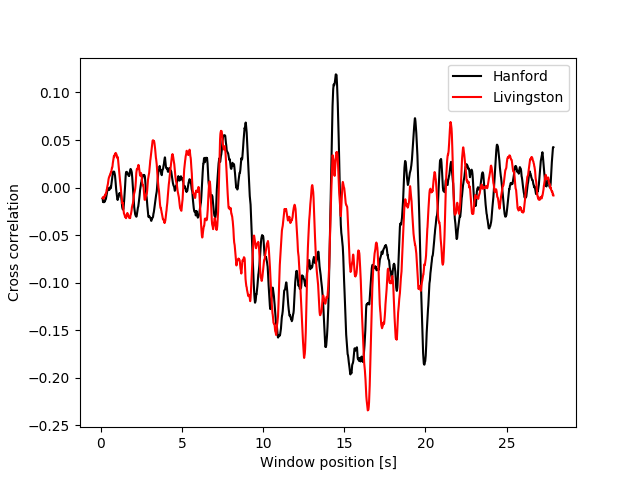

<IPython.core.display.Javascript object>


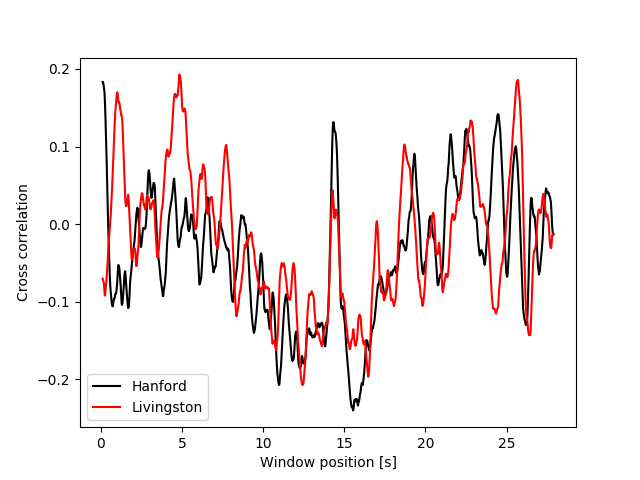

<IPython.core.display.Javascript object>


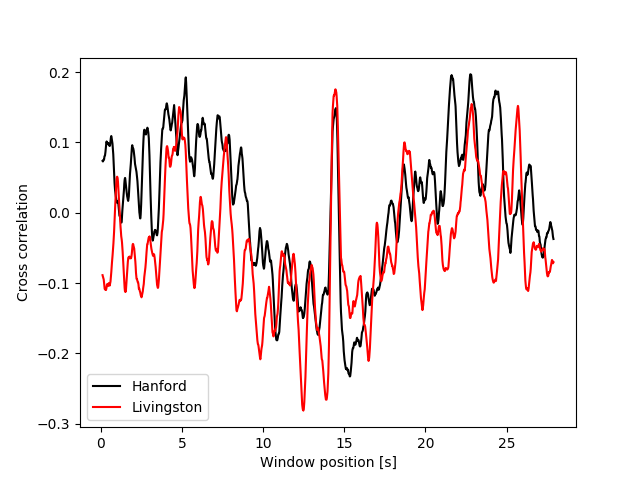

In [50]:
# Plot running window CC analysis
plt.close('all')
plt.figure(1)
plt.plot(pos_PYCBC_M, CCH_PYCBC_M, c='k', label='Hanford')
plt.plot(pos_PYCBC_M, CCL_PYCBC_M, c='r', label='Livingston')
plt.xlabel('Window position [s]')
plt.ylabel('Cross correlation')
#plt.title('RW CC PYCBC w. PYCBC method')
plt.legend()
plt.savefig('Plots/CC_PYCBC_M_SEG_%s.eps' %(psd_segment_length))

plt.figure(2)
plt.plot(pos_LOSC_M, CCH_LOSC_M, c='k', label='Hanford')
plt.plot(pos_LOSC_M, CCL_LOSC_M, c='r', label='Livingston')
plt.xlabel('Window position [s]')
plt.ylabel('Cross correlation')
#plt.title('RW CC PYCBC w. LOSC method')
plt.legend()
plt.savefig('Plots/CC_LOSC_M_SEG_%s.eps' %(psd_segment_length))

plt.figure(3)
plt.plot(pos_LOSC, CCH_LOSC, c='k', label='Hanford')
plt.plot(pos_LOSC, CCL_LOSC, c='r', label='Livingston')
plt.xlabel('Window position [s]')
plt.ylabel('Cross correlation')
#plt.title('RW CC LOSC')
plt.legend()
plt.savefig('Plots/CC_LOSC_SEG_%s.eps' %(psd_segment_length))

In [51]:
# Fourier spectrum of whitened strain

f1 = rfftfreq(len(HS_PYCBC_M), 1./4096.)
f2 = H_PSD_PYCBC_M[:,0]
f3 = rfftfreq(len(HS_LOSC), 1./4096.)

# PyCBC

FFT_H_PYCBC_M = np.abs(rfft(HS_PYCBC_M))
FFT_L_PYCBC_M = np.abs(rfft(LS_PYCBC_M))

FFT_H_LOSC_M = np.abs(rfft(HS_LOSC_M))
FFT_L_LOSC_M = np.abs(rfft(LS_LOSC_M))

# LOSC
FFT_H_LOSC = np.abs(rfft(HS_LOSC))
FFT_L_LOSC = np.abs(rfft(LS_LOSC))

<IPython.core.display.Javascript object>


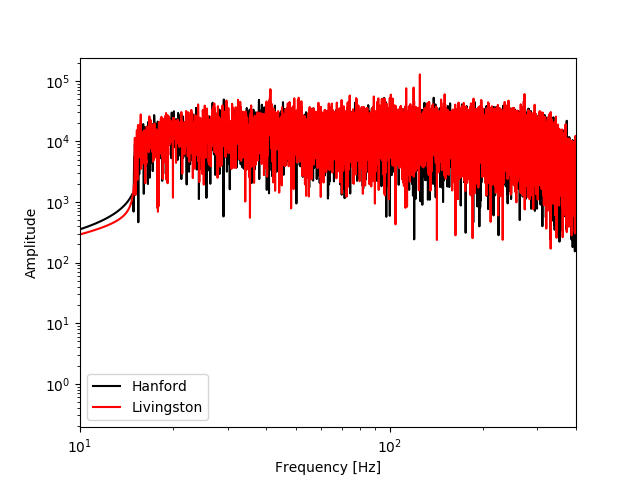

<IPython.core.display.Javascript object>


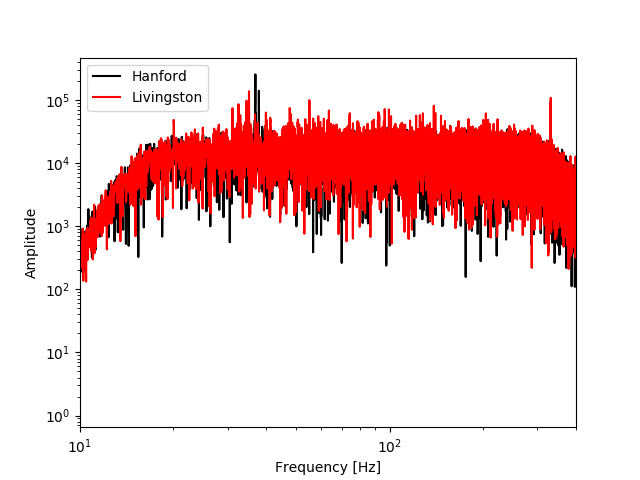

<IPython.core.display.Javascript object>


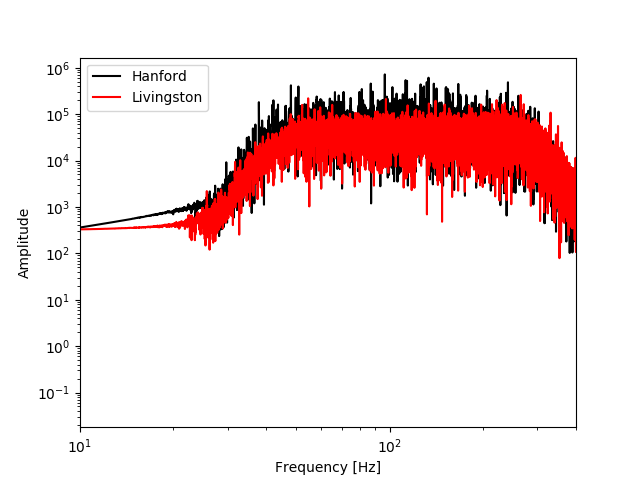

In [52]:
plt.figure(4)
plt.loglog(f1, FFT_H_PYCBC_M, c='k', label='Hanford')
plt.loglog(f1, FFT_L_PYCBC_M, c='r', label='Livingston')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.legend()
plt.xlim(10,400)
plt.savefig('Plots/FFT_PYCBC_M_SEG_%s.eps' %(psd_segment_length))

plt.figure(5)
plt.loglog(f1, FFT_H_LOSC_M, c='k', label='Hanford')
plt.loglog(f1, FFT_L_LOSC_M, c='r', label='Livingston')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.legend()
plt.xlim(10,400)
plt.savefig('Plots/FFT_LOSC_M_SEG_%s.eps' %(psd_segment_length))

plt.figure(6)
plt.loglog(f3, FFT_H_LOSC, c='k', label='Hanford')
plt.loglog(f3, FFT_L_LOSC, c='r', label='Livingston')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.legend()
plt.xlim(10,400)
plt.savefig('Plots/FFT_PYCBC_M_SEG_%s.eps' %(psd_segment_length))

<IPython.core.display.Javascript object>


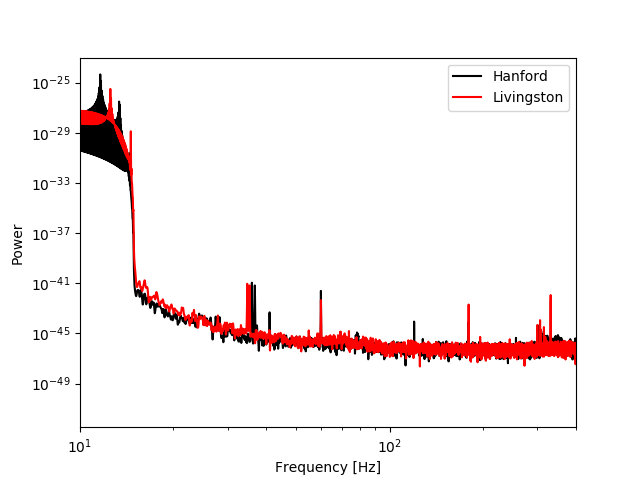

<IPython.core.display.Javascript object>


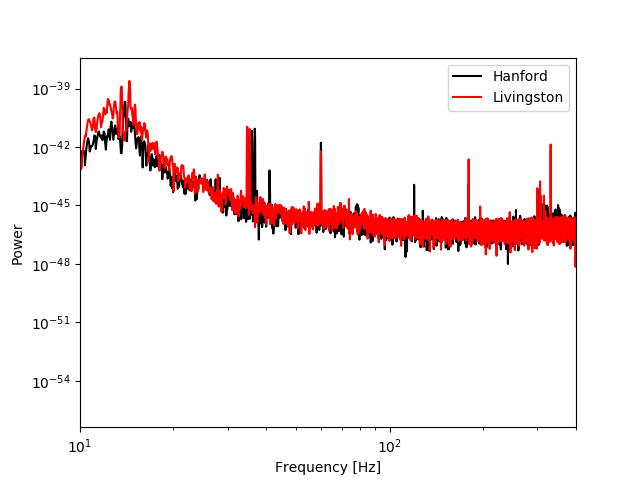

<IPython.core.display.Javascript object>


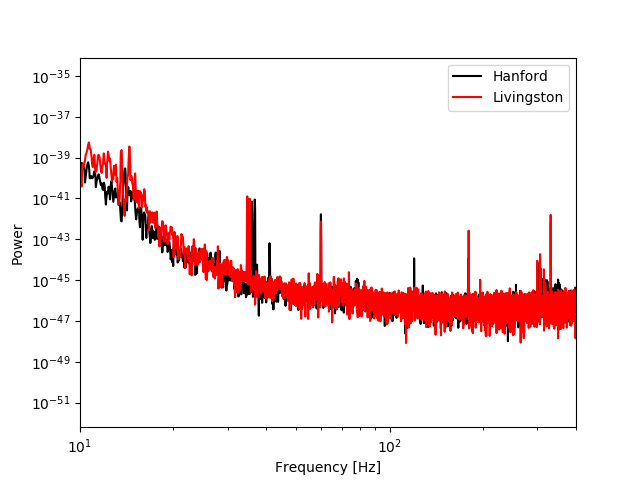

In [53]:
plt.figure(7)
plt.loglog(f2, H_PSD_PYCBC_M[:,1], c='k', label='Hanford')
plt.loglog(f2, L_PSD_PYCBC_M[:,1], c='r', label='Livingston')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.xlim(10,400)
plt.savefig('Plots/PSD_PYCBC_M_SEG_%s.eps' %(psd_segment_length))

plt.figure(8)
plt.loglog(f2, H_PSD_LOSC_M[:,1], c='k', label='Hanford')
plt.loglog(f2, L_PSD_LOSC_M[:,1], c='r', label='Livingston')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.xlim(10,400)
plt.savefig('Plots/PSD_LOSC_M_SEG_%s.eps' %(psd_segment_length))

plt.figure(9)
plt.loglog(f2, H_PSD_LOSC, c='k', label='Hanford')
plt.loglog(f2, L_PSD_LOSC, c='r', label='Livingston')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.xlim(10,400)
plt.savefig('Plots/PSD_PYCBC_M_SEG_%s.eps' %(psd_segment_length))